### Import Modules

In [342]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed


### Utils

In [343]:
# split a univariate dataset into train/test sets
def split_dataset(data,split_ratio):
    size = len(data)
    proportion = int(split_ratio*size)
    
    train, test = data[0:proportion], data[proportion:]
    train,test = array(split(train, 1)),array(split(test, 1))
    
    return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)



### Funcion para construir el modelo

In [356]:
# train the model
def build_model(train, n_input,n_output,config):
    # prepare data
    train_x, train_y = to_supervised(train, n_input,n_output)
    
    # define parameters
    verbose, epochs, batch_size = config[0],config[1],config[2]
    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(LSTM(1000, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(450, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(300, activation='relu')))
    model.add(TimeDistributed(Dense(200, activation='relu')))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model



### Carga de datos

In [374]:
dataset = pd.read_csv('Datasets/vw_emisiones_unificado.csv',
                      header=0, infer_datetime_format=True, parse_dates=['fecha'], index_col=['fecha'])
dataset.shape

(2369, 51)

In [375]:
dataset.head()

,pm_10,pm_25,pm_pst,velocidad_viento,direccion_viento,temperatura,humedad,presion_barometrica,radiacion_solar,precipitacion,...,pm_10_difference,pm_25_10,pm_25_10_1,pm_25_10_difference,pm_25_difference,pm_25_difference_2,pm_10_difference_2,pm_25_difference_3,pm_10_difference_3,day_nigth
fecha,,,,,,,,,,,,,,,,,,,,,
2019-11-11 01:00:00,50.0,13.0,43.0,0.642,157.139999,19.410000,86.480003,940.150024,45.480000,0.0,...,26.0,37.0,24.0,13.0,13.0,13.0,34.0,13.0,7.0,n
2019-11-11 02:00:00,54.0,15.0,38.0,0.728,151.979996,19.490000,86.160004,939.340027,45.250000,0.0,...,34.0,39.0,20.0,19.0,15.0,-5.0,34.0,-12.0,21.0,n
2019-11-11 03:00:00,72.0,16.0,50.0,1.070,109.699997,19.530001,85.949997,938.989990,43.270000,0.0,...,44.0,56.0,28.0,28.0,16.0,0.0,44.0,16.0,32.0,n
2019-11-11 04:00:00,66.0,21.0,49.0,1.660,121.970001,19.520000,85.989998,938.960022,44.070000,0.0,...,16.0,45.0,50.0,-5.0,21.0,2.0,44.0,-1.0,28.0,n
2019-11-11 05:00:00,51.0,26.0,43.0,1.520,118.570007,19.410000,86.589996,939.059998,43.740002,0.0,...,3.0,25.0,48.0,-23.0,26.0,5.0,23.0,5.0,10.0,n


### Seleccionar columnas

In [376]:
columns = ['pm_10','direccion_viento','humedad','presion_barometrica','radiacion_solar']
dataset = dataset[columns]
dataset.head()

,pm_10,direccion_viento,humedad,presion_barometrica,radiacion_solar
fecha,,,,,
2019-11-11 01:00:00,50.0,157.139999,86.480003,940.150024,45.480000
2019-11-11 02:00:00,54.0,151.979996,86.160004,939.340027,45.250000
2019-11-11 03:00:00,72.0,109.699997,85.949997,938.989990,43.270000
2019-11-11 04:00:00,66.0,121.970001,85.989998,938.960022,44.070000
2019-11-11 05:00:00,51.0,118.570007,86.589996,939.059998,43.740002


### Pipeline para normalizar datos

In [377]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

min_max_scl = MinMaxScaler()
min_max_scl = min_max_scl.fit(dataset)

pm10_pipeline = Pipeline([
                            ('pm10_scaler',MinMaxScaler()),
                            ('imputer',SimpleImputer(strategy = 'median'))
                        ])

exog_pipeline = Pipeline([
                            ('feature_scaler',MinMaxScaler()),
                            ('imputer',SimpleImputer(strategy = 'median'))
                        ])

full_pipeline = ColumnTransformer([
                                    ("target",pm10_pipeline,['pm_10']),
                                    ("feature",exog_pipeline,columns[1:])
                                ])
# dataset.direccion_viento = dataPrep_pipeline.fit_transform(dataset.direccion_viento.values.reshape(-1,1))
norm_dataset = full_pipeline.fit_transform(dataset)

### Separar el set de datos 

In [378]:
train, test = split_dataset(norm_dataset,0.8)

In [379]:
n_input,n_output = 3,1
epochs = 15
verbose = True
batch_size = 12
config = (verbose,epochs,batch_size)
model = build_model(train,n_input,n_output,config)

Train on 1892 samples
Epoch 1/15
1892/1892 [==============================] - 14s 7ms/sample - loss: 0.0162
Epoch 2/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0120
Epoch 3/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0114
Epoch 4/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0117
Epoch 5/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0108
Epoch 6/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0110
Epoch 7/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0109
Epoch 8/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0105
Epoch 9/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0109
Epoch 10/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0106
Epoch 11/15
1892/1892 [==============================] - 13s 7ms/sample - loss: 0.0105
Epoch 12/15
1892/1892 [=======

### Model Evaluation

In [386]:
test_x, test_y = to_supervised(test,n_input, n_output)

In [387]:
prediction = model.predict(test_x)

In [388]:
min_max_scl_pm10 = MinMaxScaler().fit(dataset.pm_10.values.reshape(-1,1))

In [389]:
prediction = min_max_scl_pm10.inverse_transform(prediction[:,0])
test_y = min_max_scl_pm10.inverse_transform(test_y)

Text(0.5, 1.0, 'Predicción de PM10')

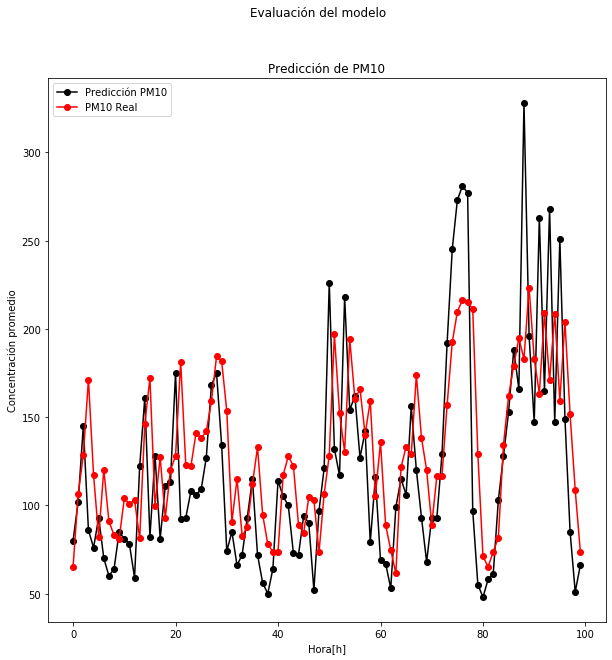

In [394]:
import matplotlib.pyplot as plt
fig_size = (10,10)
# plt.plot()
# plt.plot(test_y,color = 'blue')
# plt.plt(test_y)
fig, ax1 = plt.subplots(1, 1, figsize=fig_size)
fig.suptitle('Evaluación del modelo')

ax1.plot(test_y[75:175,0],color = 'black',marker = 'o',linestyle = '-')

ax1.plot(prediction[75:175,0],color = 'red',marker = 'o',linestyle = '-')
# ax1.axhline(y=mean_error,color = 'orange')
# ax1.axhline(y=max_error,color = 'red')
ax1.set_xlabel('Hora[h]')
ax1.set_ylabel('Concentración promedio')
ax1.legend(['Predicción PM10','PM10 Real'])
ax1.set_title('Predicción de PM10')


In [391]:
np.sqrt(np.mean((prediction-test_y)**2))

43.528495467682625

### Evaluation visualization